# Pneumonia Detection from Chest X-rays — CNN Case Study

Build a simple CNN to classify chest X-ray images as **Normal** or **Pneumonia**.

In [2]:
!curl -L -o chest-xray-pneumonia.zip\
  https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2349M  100 2349M    0     0  28.9M      0  0:01:21  0:01:21 --:--:-- 29.8M


## 1) Prepare the dataset

The expected folder structure after extraction:
```
chest_xray/
  train/
    NORMAL/
    PNEUMONIA/
  val/
    NORMAL/
    PNEUMONIA/
  test/
    NORMAL/
    PNEUMONIA/
```


In [3]:
!unzip -q chest-xray-pneumonia.zip -d /content/

## 2) Imports and helper functions

In [4]:
import os, itertools, random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# Utility: plot sample images from a generator
def plot_samples_from_dir(directory, class_label=None, n=6):
    import glob, cv2
    imgs = []
    pattern = os.path.join(directory, class_label, '*') if class_label else os.path.join(directory, '*', '*')
    files = glob.glob(pattern)
    random.shuffle(files)
    files = files[:n]
    plt.figure(figsize=(12,4))
    for i, f in enumerate(files):
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.title(os.path.basename(f))
        plt.axis('off')
    plt.show()


### Show a few sample images

Train Normal samples:


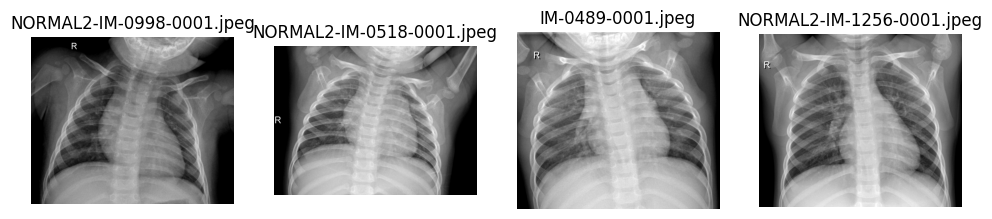

Train Pneumonia samples:


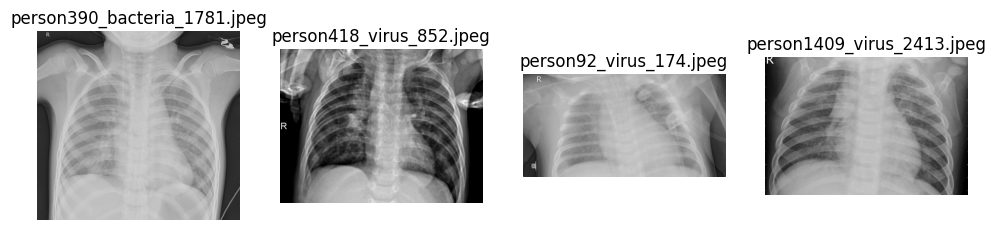

In [7]:
base_dir = '/content/chest_xray'  # default extraction path
if os.path.exists(base_dir):
    print('Train Normal samples:'); plot_samples_from_dir(os.path.join(base_dir,'train'), 'NORMAL', n=4)
    print('Train Pneumonia samples:'); plot_samples_from_dir(os.path.join(base_dir,'train'), 'PNEUMONIA', n=4)
else:
    print('Dataset folder not found at', base_dir)

## 3) Data generators & augmentation

We create Keras ImageDataGenerators for training, validation and test. Resize to 128x128 for faster demo.

In [8]:
IMG_SIZE = (128,128)
BATCH_SIZE = 32

In [9]:
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.05,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_gen = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, color_mode='rgb', batch_size=BATCH_SIZE, class_mode='binary')

Found 5216 images belonging to 2 classes.


In [13]:
val_gen   = test_datagen.flow_from_directory(val_dir,   target_size=IMG_SIZE, color_mode='rgb', batch_size=BATCH_SIZE, class_mode='binary')

Found 16 images belonging to 2 classes.


In [14]:
test_gen  = test_datagen.flow_from_directory(test_dir,  target_size=IMG_SIZE, color_mode='rgb', batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

Found 624 images belonging to 2 classes.


## 4) Build a simple CNN model

In [15]:
def build_simple_cnn(input_shape=(128,128,3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # binary classification
    ])
    return model

In [16]:
model = build_simple_cnn()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

## 5) Compile and train

We use only a few epochs for demo. Increase epochs for real training.

In [17]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
EPOCHS = 5  # small for demo; increase to 10-30 for real runs
history = model.fit(train_gen, epochs=EPOCHS, validation_data=val_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.7351 - loss: 0.5429 - val_accuracy: 0.6250 - val_loss: 1.0313
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.8717 - loss: 0.3021 - val_accuracy: 0.8125 - val_loss: 0.4530
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.8967 - loss: 0.2436 - val_accuracy: 0.6250 - val_loss: 0.7276
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.9177 - loss: 0.1989 - val_accuracy: 0.8125 - val_loss: 0.4446
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.9246 - loss: 0.1961 - val_accuracy: 0.6875 - val_loss: 0.8338


### Training & validation curves

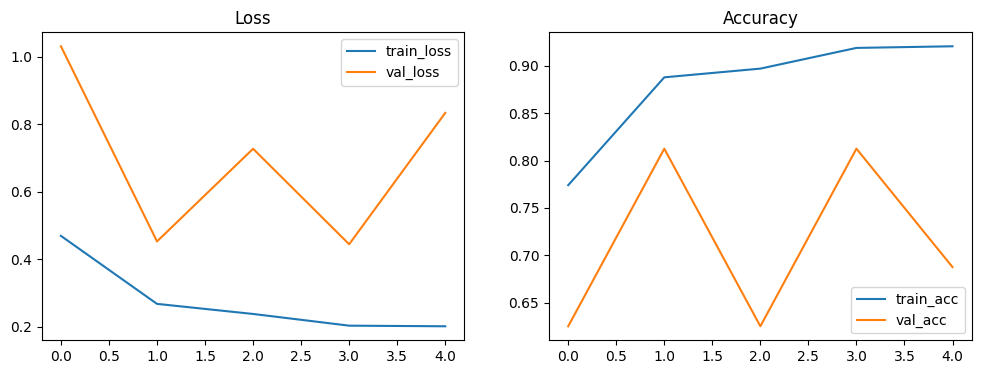

In [19]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()


## 6) Evaluate on test set and show metrics

In [20]:
# Evaluate and show confusion matrix and classification report
test_steps = test_gen.samples // test_gen.batch_size + (1 if test_gen.samples % test_gen.batch_size else 0)
test_gen.reset()
preds = model.predict(test_gen, steps=test_steps, verbose=1)
y_pred = (preds > 0.5).astype(int).reshape(-1)
y_true = test_gen.classes[:len(y_pred)]

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 502ms/step


In [21]:
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.94      0.63      0.76       234
   PNEUMONIA       0.82      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.80      0.82       624
weighted avg       0.86      0.85      0.84       624



In [22]:
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:\n', cm)

Confusion Matrix:
 [[148  86]
 [  9 381]]


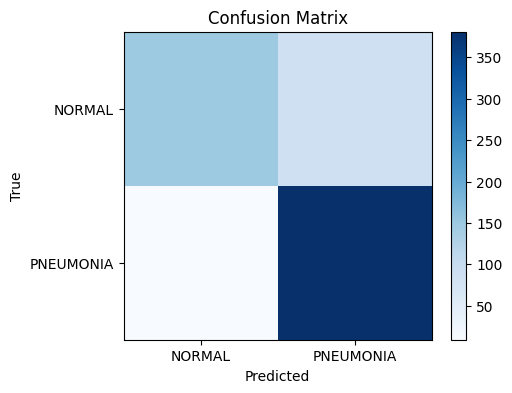

In [23]:
# Plot confusion matrix
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.xticks([0,1], list(test_gen.class_indices.keys()))
plt.yticks([0,1], list(test_gen.class_indices.keys()))
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 7) Show sample predictions

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


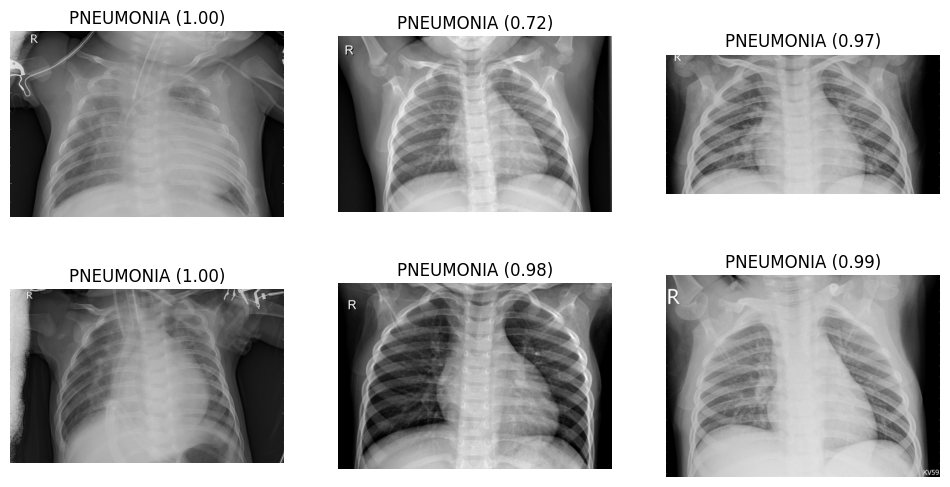

In [25]:
# Show some test images with predictions
filenames = test_gen.filenames
sample_idx = np.random.choice(len(filenames), size=6, replace=False)
plt.figure(figsize=(12,6))
for i, idx in enumerate(sample_idx):
    img_path = os.path.join(test_dir, filenames[idx])
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x = cv2.resize(img_rgb, IMG_SIZE)
    x_norm = x.astype('float32')/255.0
    pred = model.predict(x_norm[np.newaxis,...])[0][0]
    label = 'PNEUMONIA' if pred > 0.5 else 'NORMAL'
    plt.subplot(2,3,i+1)
    plt.imshow(img_rgb)
    plt.title(f'{label} ({pred:.2f})')
    plt.axis('off')
plt.show()

## 8) Visualize feature maps (first conv layer)

In [26]:
# Get output of first conv layer
from tensorflow.keras import Model

In [27]:
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name or 'Conv' in layer.__class__.__name__]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


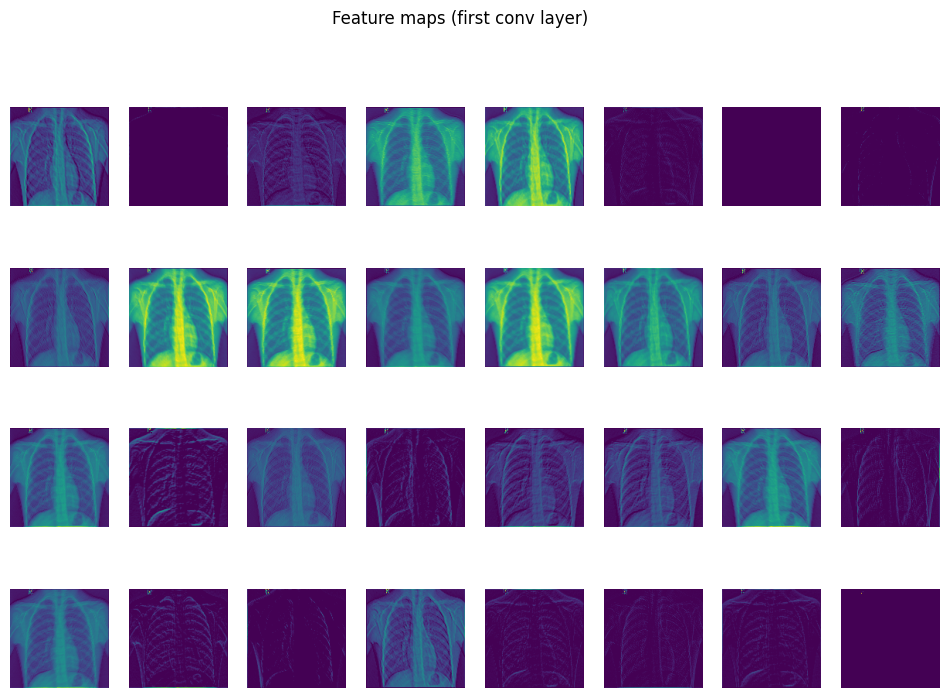

In [28]:
if len(layer_outputs) > 0:
    feature_model = Model(inputs=model.inputs, outputs=model.layers[0].output)
    # pick a sample image
    sample_img_path = os.path.join(test_dir, test_gen.filenames[0])
    import cv2
    img = cv2.imread(sample_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x = cv2.resize(img, IMG_SIZE).astype('float32')/255.0
    fmap = feature_model.predict(x[np.newaxis,...])
    n_filters = fmap.shape[-1]
    plt.figure(figsize=(12, int(np.ceil(n_filters/8))*2))
    for i in range(min(n_filters, 32)):
        plt.subplot(int(np.ceil(min(n_filters,32)/8)), 8, i+1)
        plt.imshow(fmap[0,:,:,i], cmap='viridis')
        plt.axis('off')
    plt.suptitle('Feature maps (first conv layer)')
    plt.show()
else:
    print('No conv layers found in model')

## 9) Save the trained model

In [29]:
# Save model weights and full model
model.save('/content/pneumonia_cnn_model.h5')
print('Saved model to /content/pneumonia_cnn_model.h5')

Saved model to /content/pneumonia_cnn_model.h5
